<a href="https://colab.research.google.com/github/ahmethakankaragulle/DetectionOfRespiratoryDiseases/blob/main/DetectionOfRespiratoryDiseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmethakankaragulle","key":"f0259d281fd4a44c65f390786d85559a"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d vbookshelf/respiratory-sound-database

100% 3.69G/3.69G [02:53<00:00, 24.3MB/s]
100% 3.69G/3.69G [02:53<00:00, 22.8MB/s]


In [5]:
import os
import zipfile

local_zip = '/content/respiratory-sound-database.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')

In [6]:
from datetime import datetime
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import sklearn
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [7]:
dataset_path = "/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"

filenames = [f for f in listdir(dataset_path) if (isfile(join(dataset_path, f)) and f.endswith('.wav'))]

patient_ids = [] # Hasta kimlikleri
for name in filenames:
    patient_ids.append(int(name[:3]))

In [8]:
max_mfcc_len = 862 # MFCC lerin uzunluğu

def audio_to_mfcc(file_name):
    #ses dosyalarının MFCC'ye dönüştürülmesi
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_mfcc_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print("Dosya ayrıştırılırken hata oluştu: ", file_name)
        return None

    return mfccs

In [9]:
filepaths = [join(dataset_path, f) for f in filenames]

patient_csv = pd.read_csv("/content/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None)

labels = np.array([patient_csv[patient_csv[0] == x][1].values[0] for x in patient_ids]) 

In [10]:
# tüm ses dosyalarını mfcc ye dönüştürme
features = []

for file_name in filepaths:
    data = audio_to_mfcc(file_name)
    features.append(data)

print('Bitmiş özellik çıkarımı ', len(features), ' dosya')
features = np.array(features)

Bitmiş özellik çıkarımı  920  dosya


In [11]:
# Astım hastalığını datasetten çıkarma
features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)
labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)


In [12]:
# Sınıf sayısı
unique_elements, counts_elements = np.unique(labels1, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]


In [13]:
# One-hot encode
le = sklearn.preprocessing.LabelEncoder()
i_labels = le.fit_transform(labels1)
oh_labels = tf.keras.utils.to_categorical(i_labels)
features1 = np.reshape(features1, (*features1.shape,1))

In [14]:
# test ve eğitim verilerini ayırma
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(features1, oh_labels, 
                                                    stratify=oh_labels, test_size=0.2, random_state = 42)

In [15]:
#------------MODEL-----------
num_rows = 40
num_columns = 862
channel = 1
filter_size = 2
num_classes = oh_labels.shape[1]

model = keras.Sequential()

model.add(layers.Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, channel), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(num_classes, activation='softmax'))


# Model Compile
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Model Özeti
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 861, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 430, 16)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 430, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 429, 32)       2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 214, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 214, 32)        0

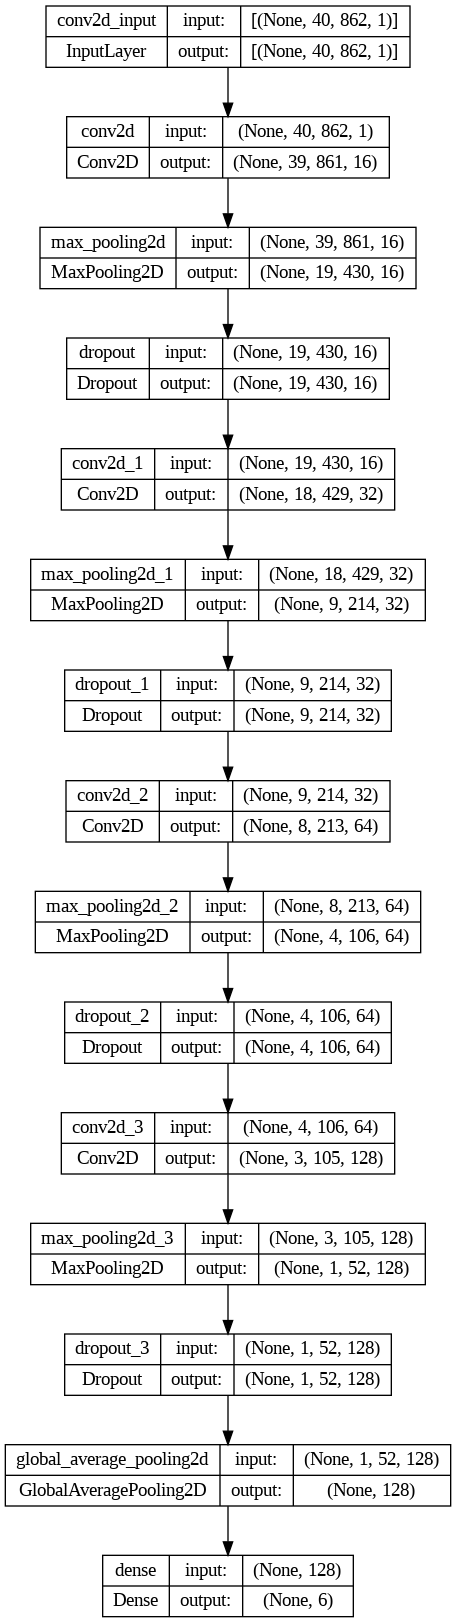

In [16]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [17]:
#--------Model Eğitimi-------
epochs = 250
batch_size = 128
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          validation_data=(x_test, y_test), verbose=1)


Epoch 1/250
6/6 [==============================] - 15s 446ms/step - loss: 9.8232 - accuracy: 0.7080 - val_loss: 5.5495 - val_accuracy: 0.0761
Epoch 2/250
6/6 [==============================] - 1s 92ms/step - loss: 6.3149 - accuracy: 0.7381 - val_loss: 3.0105 - val_accuracy: 0.2391
Epoch 3/250
6/6 [==============================] - 1s 89ms/step - loss: 3.7939 - accuracy: 0.7613 - val_loss: 1.1044 - val_accuracy: 0.8533
Epoch 4/250
6/6 [==============================] - 1s 91ms/step - loss: 1.9931 - accuracy: 0.7981 - val_loss: 2.3275 - val_accuracy: 0.4076
Epoch 5/250
6/6 [==============================] - 1s 94ms/step - loss: 1.5000 - accuracy: 0.8117 - val_loss: 0.7947 - val_accuracy: 0.8424
Epoch 6/250
6/6 [==============================] - 1s 95ms/step - loss: 1.2730 - accuracy: 0.8267 - val_loss: 0.9513 - val_accuracy: 0.7446
Epoch 7/250
6/6 [==============================] - 1s 95ms/step - loss: 1.0195 - accuracy: 0.8336 - val_loss: 0.9264 - val_accuracy: 0.7446
Epoch 8/250
6/6 [=

In [18]:
# Modelin eğitim ve test seti üzerinde başarısı
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9195088744163513
Testing Accuracy:  0.907608687877655


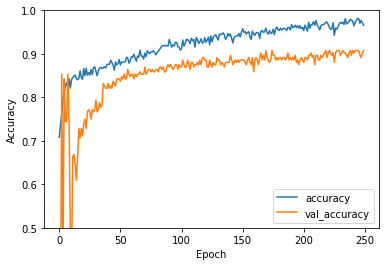

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=0)



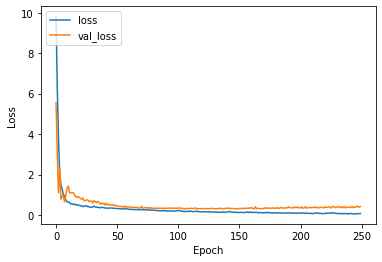

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()